In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
import colorsys
import random
from matplotlib.pyplot import imshow
%matplotlib inline

input_size = 416
iou = 0.4 #iou threshold
score = 0.25 #score threshold
class_names = "./classes.names"
image_path = "./test.jpg"

In [2]:
def read_class_names(class_file_name):
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

In [3]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image_data = cv2.resize(original_image, (input_size, input_size))
image_data = image_data / 255.

images_data = np.asarray(image_data).astype(np.float32)
images_data = np.expand_dims(images_data, axis = 0)

In [4]:
interpreter = tf.lite.Interpreter(model_path=r".\yolov3-tiny-416-int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

In [5]:
interpreter.set_tensor(input_details[0]['index'], images_data)

interpreter.invoke()

pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

In [6]:
def filter_boxes(box_xywh, scores, score_threshold=0.4, input_shape = tf.constant([416,416])):
    scores_max = tf.math.reduce_max(scores, axis=-1)

    mask = scores_max >= score_threshold
    class_boxes = tf.boolean_mask(box_xywh, mask)
    pred_conf = tf.boolean_mask(scores, mask)
    class_boxes = tf.reshape(class_boxes, [tf.shape(scores)[0], -1, tf.shape(class_boxes)[-1]])
    pred_conf = tf.reshape(pred_conf, [tf.shape(scores)[0], -1, tf.shape(pred_conf)[-1]])

    box_xy, box_wh = tf.split(class_boxes, (2, 2), axis=-1)

    input_shape = tf.cast(input_shape, dtype=tf.float32)

    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]

    box_mins = (box_yx - (box_hw / 2.)) / input_shape
    box_maxes = (box_yx + (box_hw / 2.)) / input_shape
    boxes = tf.concat([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ], axis=-1)
    # return tf.concat([boxes, pred_conf], axis=-1)
    return (boxes, pred_conf)

In [7]:
boxes, pred_conf = filter_boxes(pred[1], pred[0], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))

In [8]:
boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(
            pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=iou,
        score_threshold=score
    )

In [9]:
pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]

In [10]:
def draw_bbox(image, bboxes, classes=read_class_names(class_names), show_label=True):
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    out_boxes, out_scores, out_classes, num_boxes = bboxes
    for i in range(num_boxes[0]):
        if int(out_classes[0][i]) < 0 or int(out_classes[0][i]) > num_classes: continue
        coor = out_boxes[0][i]
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)

        fontScale = 0.5
        score = out_scores[0][i]
        class_ind = int(out_classes[0][i])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[1], coor[0]), (coor[3], coor[2])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick // 2)[0]
            c3 = (c1[0] + t_size[0], c1[1] - t_size[1] - 3)
            cv2.rectangle(image, c1, (np.float32(c3[0]), np.float32(c3[1])), bbox_color, -1) #filled

            cv2.putText(image, bbox_mess, (c1[0], np.float32(c1[1] - 2)), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick // 2, lineType=cv2.LINE_AA)
    return image

In [11]:
image = draw_bbox(original_image, pred_bbox)

In [12]:
image = Image.fromarray(image.astype(np.uint8))

In [13]:
image.show()

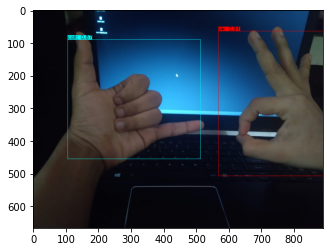

In [14]:
imshow(image)

In [ ]:
# image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
# cv2.imwrite("./result.png", image)